In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meenakshirathod51","key":"a30047f49852b2bc0cd64e533053110e"}'}

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test_FD001.txt to test_FD001.txt
Saving RUL_FD001.txt to RUL_FD001.txt
Saving train_FD001.txt to train_FD001.txt


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!cat ~/.kaggle/kaggle.json


{"username":"meenakshirathod51","key":"a30047f49852b2bc0cd64e533053110e"}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - loss: 10694.3857 - val_loss: 12371.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 8668.1719 - val_loss: 10518.1826
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 7051.4629 - val_loss: 9069.9658
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 5969.6025 - val_loss: 7960.5132
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 5158.5933 - val_loss: 7366.6670
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - loss: 4543.8984 - val_loss: 6843.5161
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 3745.3235 - val_loss: 5249.4204
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 3032.6975 - val_loss: 4531.4170
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - loss: 2614.5806 - val_loss: 4053.3931
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 2204.3022 - val_loss: 3473.7651
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step -

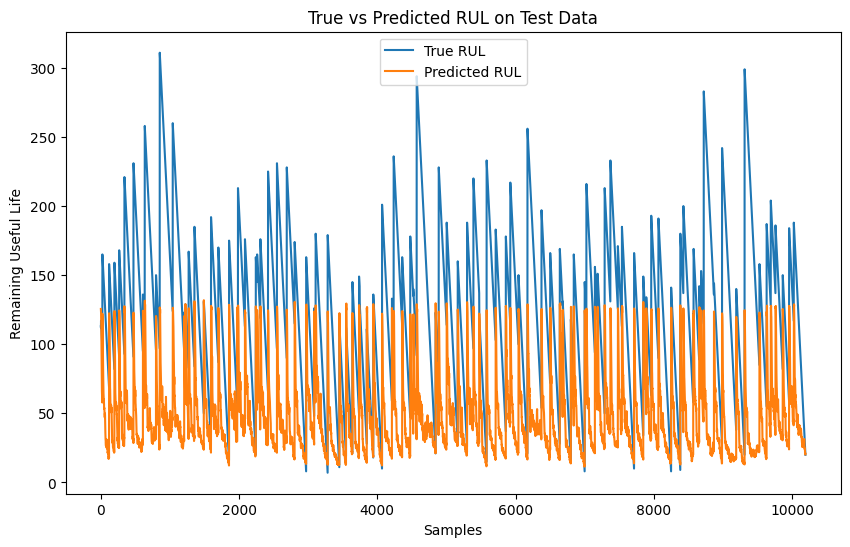

In [ ]:
 # 🚀 Engine Remaining Useful Life (RUL) Prediction - Clean Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load training data
column_names = ['engine_id', 'cycle'] + \
               [f'op_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_{i}' for i in range(1, 22)]

train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)

# Step 2: Identify and drop constant columns
train_df_raw = train_df.copy()
constant_cols = [col for col in train_df_raw.columns if train_df_raw[col].nunique() == 1]
train_df = train_df.drop(columns=constant_cols)

# Step 3: Create RUL (Remaining Useful Life) label
rul = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul.columns = ['engine_id', 'max_cycle']
train_df = train_df.merge(rul, on='engine_id', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Step 4: Normalize selected columns
cols_to_normalize = train_df.columns.difference(['engine_id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])

# Step 5: Prepare sequences for LSTM
def generate_sequences(df, seq_len, feature_cols):
    seq_data = []
    seq_labels = []
    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id]
        for i in range(len(engine_data) - seq_len + 1):
            seq = engine_data[feature_cols].iloc[i:i+seq_len].values
            label = engine_data['RUL'].iloc[i + seq_len - 1]
            seq_data.append(seq)
            seq_labels.append(label)
    return np.array(seq_data), np.array(seq_labels)

feature_columns = [col for col in train_df.columns if col not in ['engine_id', 'RUL']]
sequence_length = 30
X_train, y_train = generate_sequences(train_df, sequence_length, feature_columns)

# Step 6: Build LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, len(feature_columns))))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

# Step 7: Load test data
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
rul_test_df = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

test_df = test_df.drop(columns=constant_cols)

max_cycles_test = test_df.groupby('engine_id')['cycle'].max().reset_index()
max_cycles_test.columns = ['engine_id', 'max_cycle']
test_rul_merged = max_cycles_test.merge(rul_test_df, left_index=True, right_index=True)
test_df = test_df.merge(test_rul_merged[['engine_id', 'max_cycle', 'RUL']], on='engine_id', how='left')
test_df['RUL'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['cycle'])
test_df.drop('max_cycle', axis=1, inplace=True)

test_df = test_df[['engine_id', 'RUL', 'cycle'] + list(cols_to_normalize)]
test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])

# Re-define test feature columns after scaling
feature_columns = [col for col in test_df.columns if col not in ['engine_id', 'RUL']]


X_test, y_test = generate_sequences(test_df, sequence_length, feature_columns)

# Step 8: Prediction and Evaluation
y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {rmse_test:.2f}')

# Step 9: Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('Remaining Useful Life')
plt.title('True vs Predicted RUL on Test Data')
plt.legend()
plt.show()
